## 1. Defining the Question

### a) Specifying the Question


> Coming up with a model that detects traffic signs



### b) Defining the Metric for Success






*   Data wrangling
*   Feature Engineering
*   Tensor flow
*   Keras










### c) Understanding the context 

this is a multi-class, single-image classification challenge that we got from kaggle. it is designed to allow participation without any domain knowledge.

### d) Recording the Experimental Design





>  Do Keras



### e) Data Relevance

data is gotten from kaggle. we expect to see images of traffic signs like, pedestrian crossing

## 2. Reading the Data

this data was quite unique in its own nature. so we had to clone the data from a repository https://bitbucket.org/jadslim/german-traffic-signs. 

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


we also cloned the german traffic signs from the same repository stated above

In [2]:
!dir german-traffic-signs

signnames.csv  test.p  train.p	valid.p


we now imported the prerequisities that we need. 

In [0]:


import time as time

import numpy as np
np.random.seed(40)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
%matplotlib inline

from PIL import Image
import time
from datetime import timedelta
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import skimage.morphology as morp
from skimage.filters import rank

import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout # new!
from keras.layers.normalization import BatchNormalization # new!
from keras import regularizers # new! 
from keras.optimizers import SGD
from keras.layers import Flatten, Conv2D, MaxPooling2D # new!
from keras.callbacks import ModelCheckpoint

import cv2

In [0]:
import pickle
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

## Checking the Data

In [0]:
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

In [6]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [9]:
print("Training Set:", len(x_train))
print("Test Set:", len(y_test))
print("Validation Set:", len(x_val))
print("Image Dimensions:", np.shape(x_train[1]))
print("Number of classes:", len(np.unique(y_train)))
n_classes = len(np.unique(y_train))

Training Set: 34799
Test Set: 12630
Validation Set: 4410
Image Dimensions: (32, 32, 3)
Number of classes: 43


## Basic Descriptive analysis

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42]
 [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
   690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
   480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
   210]]


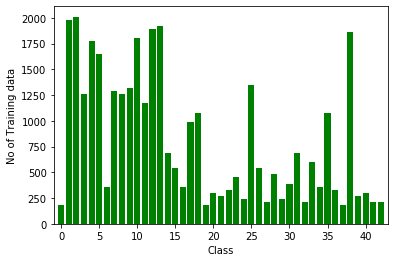

 
We can definitely see class bias issue as certain classes are under represented
 
 
Traffic Sign Images


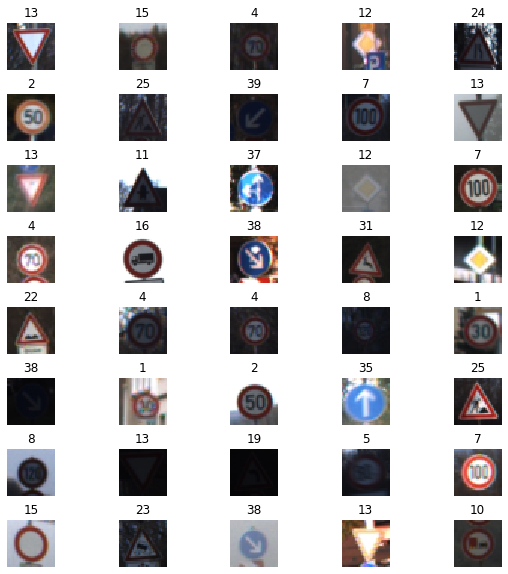

In [15]:
# Checking for class bias 

unique_elements, counts_elements = np.unique(y_train, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 43 ), counts_elements, align='center',color='green' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 43])

plt.show()

print(" ")
print("We can definitely see class bias issue as certain classes are under represented")

# View few images

import matplotlib.pyplot as plt
import random

%matplotlib inline
print(" ")
print(" ")
print("Traffic Sign Images")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(x_train))
    image = x_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

## Model Testing without any preprocessing 

**Establishing Baseline**

*Neural Network Architecture*

In [0]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))

In [25]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               393344    
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)              

In [0]:

x_train_baseline = x_train.reshape(len(x_train), 32*32*3).astype('float32')
x_val_baseline = x_val.reshape(len(x_val), 32*32*3).astype('float32')
y_train_baseline = keras.utils.to_categorical(y_train, n_classes)
y_val_baseline = keras.utils.to_categorical(y_val, n_classes)

In [33]:

model.fit(x_train_baseline, y_train_baseline, batch_size=128, epochs=100, verbose=1, validation_data=(x_val_baseline, y_val_baseline))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 34799 samples, validate on 4410 samples
Epoch 1/100





34799/34799 [==============================] - 14s 391us/step - loss: 2.7169 - acc: 0.2701 - val_loss: 1.8923 - val_acc: 0.4231
Epoch 2/100
34799/34799 [==============================] - 3s 82us/step - loss: 1.3884 - acc: 0.5736 - val_loss: 1.7326 - val_acc: 0.5168
Epoch 3/100
34799/34799 [==============================] - 3s 80us/step - loss: 0.9750 - acc: 0.7021 - val_loss: 0.9717 - val_acc: 0.7163
Epoch 4/100
34799/34799 [==============================] - 3s 79us/step - loss: 0.7631 - acc: 0.7655 - val_loss: 0.9364 - val_acc: 0.7132
Epoch 5/100
34799/34799 [==============================] - 3s 80us/step - loss: 0.6652 - acc: 0.7977 - val_loss: 0.8119 - val_acc: 0.7728
Epoch 6/100
34799/34799 [==============================] - 3s 85us/step - loss: 0.5772 - acc: 0.8257 - val_loss: 0.8345 - val_acc: 0.7406
Epoch 7/100
34799/3

In [0]:
x_test_baseline = x_test.reshape(len(x_test), 32*32*3).astype('float32')
y_test_baseline = keras.utils.to_categorical(y_test, n_classes)

In [35]:
Pred = model.evaluate(x_test_baseline, y_test_baseline, verbose=0)
print("Dense fully connected network results on the test data - Baseline ")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - Baseline 
 
loss- 0.59
acc- 0.89


we get an accuracy of 89%. this is a very good model. now lets go on further and check for other preprocessing techniques.

## *Data Augmentation*

In [0]:

def data_augment(image):
    rows= image.shape[0]
    cols = image.shape[1]
    
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),10,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
    #img = cv2.warpAffine(img,M_aff,(cols,rows))
    
    # Bilateral filtering
    img = cv2.bilateralFilter(img,9,75,75)
    return img

Increase training set by augmentation and making all class size similar

In [0]:

classes = 43

X_train_final = x_train
y_train_final = y_train
X_aug_1 = []
Y_aug_1 = []

for i in range(0,classes):
    
    class_records = np.where(y_train==i)[0].size
    max_records = 4000
    if class_records != max_records:
        ovr_sample = max_records - class_records
        samples = x_train[np.where(y_train==i)[0]]
        X_aug = []
        Y_aug = [i] * ovr_sample
        
        for x in range(ovr_sample):
            img = samples[x % class_records]
            trans_img = data_augment(img)
            X_aug.append(trans_img)
            
        X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
        y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
        Y_aug_1 = Y_aug_1 + Y_aug
        X_aug_1 = X_aug_1 + X_aug

# *Check class bias after augmentation*

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42]
 [4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000]]


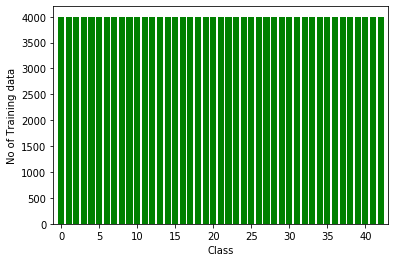

In [40]:

unique_elements, counts_elements = np.unique(y_train_final, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

pyplot.bar( np.arange( 43 ), counts_elements, align='center',color='green' )
pyplot.xlabel('Class')
pyplot.ylabel('No of Training data')
pyplot.xlim([-1, 43])

pyplot.show()


**Shape of the datasets after data augmentation**

In [42]:
print(len(x_train))
print(len(X_train_final))
print(len(y_train))
print(len(y_train_final))

34799
172000
34799
172000


**View images after data augmentation**

 
 
Let's view few images to understand our transformations


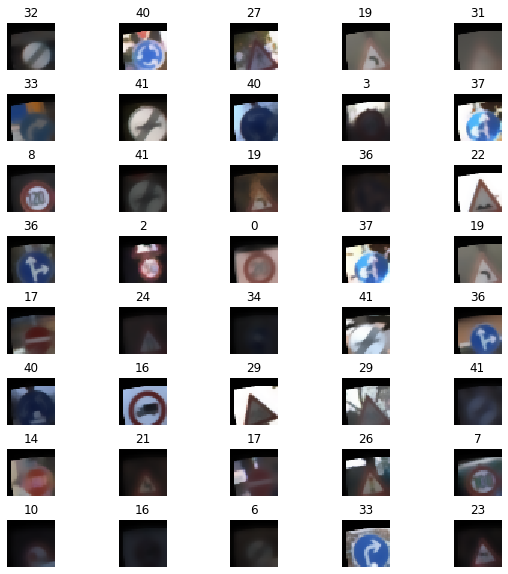

In [43]:


print(" ")
print(" ")
print("Let's view few images to understand our transformations")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = random.randint(0, len(X_aug_1))
    image = X_aug_1[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(Y_aug_1[index])

**Model Testing after Augmentation**

In [0]:

X_train_aug = X_train_final.reshape(len(X_train_final), 32*32*3).astype('float32')
X_valid_aug = x_val.reshape(len(x_val), 32*32*3).astype('float32')
y_train_aug = keras.utils.to_categorical(y_train_final, n_classes)
y_valid_aug = keras.utils.to_categorical(y_val, n_classes)


In [0]:

filepath="German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [50]:
model.fit(X_train_aug, y_train_aug, batch_size=128, epochs=100, verbose=1,callbacks=callbacks_list,validation_data=(X_valid_aug, y_valid_aug))

Train on 172000 samples, validate on 4410 samples
Epoch 1/100
172000/172000 [==============================] - 14s 79us/step - loss: 1.4165 - acc: 0.6036 - val_loss: 0.6145 - val_acc: 0.8331

Epoch 00001: val_acc improved from -inf to 0.83311, saving model to German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5
Epoch 2/100
172000/172000 [==============================] - 13s 78us/step - loss: 0.7746 - acc: 0.7622 - val_loss: 0.6810 - val_acc: 0.8308

Epoch 00002: val_acc did not improve from 0.83311
Epoch 3/100
172000/172000 [==============================] - 14s 79us/step - loss: 0.6178 - acc: 0.8103 - val_loss: 0.5379 - val_acc: 0.8524

Epoch 00003: val_acc improved from 0.83311 to 0.85238, saving model to German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5
Epoch 4/100
172000/172000 [==============================] - 14s 79us/step - loss: 0.5412 - acc: 0.8328 - val_loss: 0.5871 - val_acc: 0.8549

Epoch 00004: val_acc improved from 0.85238 to 0.85488, saving model to German_Tra

In [0]:

X_test_aug = x_test.reshape(len(x_test), 32*32*3).astype('float32')
y_test_aug = keras.utils.to_categorical(y_test, n_classes)

In [0]:
model.load_weights("German_Traffic_DenseNetworkModel_AfterAugmentation.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:

Pred = model.evaluate(X_test_aug, y_test_aug, verbose=0)
print("Dense fully connected network results on the test data - After Data Augmentation ")
print(" ")
print("%s- %.2f" % (model.metrics_names[0], Pred[0]))
print("%s- %.2f" % (model.metrics_names[1], Pred[1]))

Dense fully connected network results on the test data - After Data Augmentation 
 
loss- 0.68
acc- 0.86


the accuracy score is now at 86%. this is lower than the baseline. lets continue exploring with the preproccessing techniques.

## **Gray Scaling**

 
 
Let's view few images to familiarize


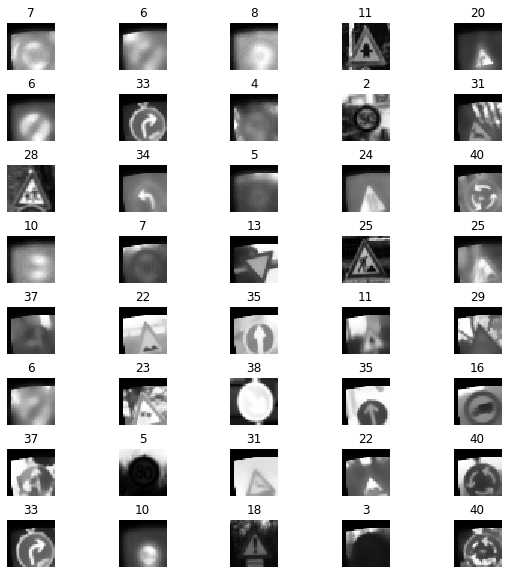

In [56]:

def gray_scale(image):
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images_data = list(map(gray_scale, X_train_final))


%matplotlib inline
print(" ")
print(" ")
print("Let's view few images to familiarize")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = np.random.randint(0, len(gray_images_data))
    image = gray_images_data[index]
    axs[i].axis('off')
    axs[i].imshow(image,cmap='gray')
    axs[i].set_title(y_train_final[index])

 
 
Let's view few images after applying local histogram equilization and Gray scaling


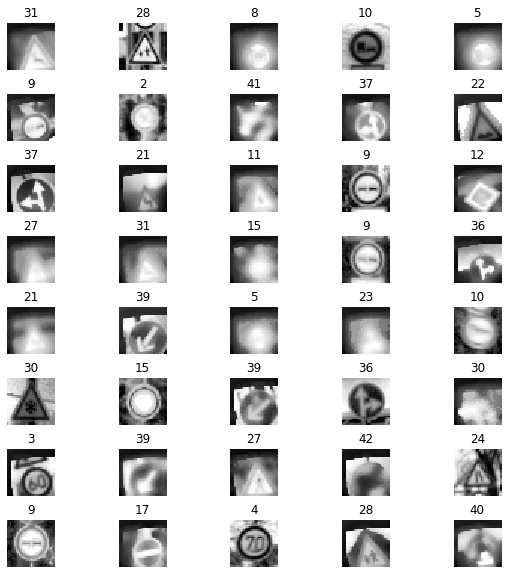

In [57]:
def local_histo_equalize(image):
    
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local


local_histo = np.array(list(map(local_histo_equalize, gray_images_data)))
%matplotlib inline
print(" ")
print(" ")
print("Let's view few images after applying local histogram equilization and Gray scaling")
fig, axs = plt.subplots(8,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(40):
    index = np.random.randint(0, len(local_histo))
    image = local_histo[index]
    axs[i].axis('off')
    axs[i].imshow(image,cmap = 'gray')
    axs[i].set_title(y_train_final[index])

In [0]:
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = np.divide(img,255)
    normalized_images = normalized_images[..., None]
    return normalized_images

Apply Grayscaling and local histogram equalization to the training and the validation data

In [0]:
X_train_preprocessed = preprocess(X_train_final)
X_valid_preprocessed = preprocess(x_val)

In [0]:

X_train_preprocessed_dn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32*32*1).astype('float32')
X_valid_preprocessed_dn = X_valid_preprocessed.reshape(len(X_valid_preprocessed), 32*32*1).astype('float32')

In [0]:

y_train_final_dn = keras.utils.to_categorical(y_train_final, n_classes)
y_valid_final_dn = keras.utils.to_categorical(y_val, n_classes)

Check the shape of the datasets after all preprocessing

In [66]:
print(X_train_preprocessed_dn.shape)
print(X_valid_preprocessed_dn.shape)
print(y_train_final_dn.shape)
print(y_valid_final_dn.shape)


(172000, 1024)
(4410, 1024)
(172000, 43)
(4410, 43)


Compile and fit the model after preprocessing

Neural network architecture after grayscaling

In [0]:

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(32*32*1,)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Save model with Checkpoint

In [0]:

filepath="German_Traffic_DenseNetworkModel_final.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [75]:
model.fit(X_train_preprocessed_dn, y_train_final_dn, batch_size=128, epochs=100, verbose=1,callbacks=callbacks_list,validation_data=(X_valid_preprocessed_dn, y_valid_final_dn))

Train on 172000 samples, validate on 4410 samples
Epoch 1/100
172000/172000 [==============================] - 14s 83us/step - loss: 1.7085 - acc: 0.5115 - val_loss: 1.7504 - val_acc: 0.4658

Epoch 00001: val_acc improved from -inf to 0.46576, saving model to German_Traffic_DenseNetworkModel_final.hdf5
Epoch 2/100
172000/172000 [==============================] - 13s 76us/step - loss: 0.9564 - acc: 0.7097 - val_loss: 1.3885 - val_acc: 0.5569

Epoch 00002: val_acc improved from 0.46576 to 0.55692, saving model to German_Traffic_DenseNetworkModel_final.hdf5
Epoch 3/100
172000/172000 [==============================] - 12s 73us/step - loss: 0.7883 - acc: 0.7586 - val_loss: 1.2278 - val_acc: 0.6011

Epoch 00003: val_acc improved from 0.55692 to 0.60113, saving model to German_Traffic_DenseNetworkModel_final.hdf5
Epoch 4/100
172000/172000 [==============================] - 13s 76us/step - loss: 0.6972 - acc: 0.7847 - val_loss: 0.8885 - val_acc: 0.7091

Epoch 00004: val_acc improved from 0.601


prepare test data for final results

In [0]:

## Prepare the Test data with all the preprocessing

X_test_preprocessed = preprocess(x_test)
X_test_preprocessed_dn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32*32*1).astype('float32')
y_test_final_dn = keras.utils.to_categorical(y_test, n_classes)


Load the best model from the validation data results

In [0]:
model.load_weights("German_Traffic_DenseNetworkModel_final.hdf5")

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:

Pred = model.evaluate(X_test_preprocessed_dn, y_test_final_dn, verbose=0)
print("Dense fully connected network results on the test data")
print(" ")
print("%s- %.2f%%" % (model.metrics_names[0], Pred[0]*100))
print("%s- %.2f%%" % (model.metrics_names[1], Pred[1]*100))

Dense fully connected network results on the test data
 
loss- 55.81%
acc- 86.17%


the accuracy score is still lower than the baseline and almost similar to the augmentation. the best model is baseline.

## Challenging the solution

the model is performing very well. however, hyperparameter tuning can be used so as to improve its performance.

## 9. Follow up questions

> At this point, we can refine our question or collect new data, all in an iterative process to get at the truth.



### a). Did we have the right data?



> we did have the right data



### b). Do we need other data to answer our question?



> No. this data was enough



### c). Did we have the right question?



> yes. we had the right question since domain knowledge was not needed

